In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from math import log10
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from astropy.table import Table
from astropy.cosmology import Planck13
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from scipy import misc
from scipy.ndimage import zoom
from scipy.ndimage.interpolation import rotate
import glob
from astropy.io import fits
from astropy.table import Table
from math import log10
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.pyplot import imread
from scipy.ndimage import zoom
from scipy.ndimage.interpolation import rotate
import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import rmsprop

import random
import pdb
import time

from sklearn.utils import shuffle

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json
from keras.models import model_from_yaml
from keras.optimizers import SGD

%matplotlib inline

Using TensorFlow backend.


# Read Catalog Data
Remember to change the path to the catalog
This cell reads the catalog. There is a line in the catalog for every galaxy. There are many parameters measured for every galaxy (colors, redshift, sizes, halo masses, veolcity dispersions etc..). Any of them can be used as an input feature. Ask me if you need clarification.

In [2]:
# this path needs to be changed
cat="Nair_Abraham_cat.fit"
data=fits.getdata(cat,1)
t=Table(data)
print(t)
print(t.colnames)

     dr7objid              SDSS            RA   ... tails   RC3     Tt_2  
------------------ -------------------- ------- ... ----- ------- --------
587748927626149924 J112408.63-010927.83 171.036 ...   0.0 .LXR0..      2.0
587748927626870899 J113057.91-010851.06 172.742 ...   0.0 999999       0.5
587748927627722875 J113833.27-011104.16 174.639 ...   0.0 .SXR2?.      3.5
587722981742084144 J121808.55-010350.82 184.536 ...   0.0 .SXT4..      3.5
587722981744640177 J124159.07-011043.98 190.497 ...   0.0 PSBS2..      3.0
587722981744771128 J124257.26-011345.93 190.739 ...   0.0 .SAS6*/      4.5
587722981745295552 J124752.98-011109.04 191.971 ...   0.0 .S..7*/      4.0
587722981745426489 J124859.91-010935.43  192.25 ...   0.0 999999       1.5
587722981747392587 J130705.63-011036.63 196.774 ...   0.0 999999       4.0
587722981748048006 J131236.98-011151.02 198.155 ...   0.0 999999       3.5
               ...                  ...     ... ...   ...     ...      ...
587738568708980870 J13114

# Read Images (optional here)

In [3]:
pathsave="E_vs_S/"

# number of images to read (up to 10.000)
maxim=50


# to cut stamps -- ignore
def extract_thumb(im,x,y,size):
    if size %2==0:
        size = size+1
    up_x=int(x-size/2)
    dow_x=int(x+size/2)
    up_y=int(y-size/2)
    dow_y=int(y+size/2)
    res=im[up_x:dow_x,up_y:dow_y]        
    return res 

# this function only reads jpeg images and saves them to a numpy array. images are rebnned to a 69*68 pixel size to 
# speed computation in the CNN part.
# not very "clean" -- sorry
def read_data(pathsave,maxim):
    
    # image size that will go into the network (this is only for the deep learning part, not the RF)
    size_im=69
    size_crop=207
  

    data=fits.getdata('Nair_Abraham_cat.fit',1)
    idcat=data['dr7objid']
    ttype=data['TType']
    
    #define the morphologies we want to retrieve
    m=ttype*0-1
    # this should select elliptical galaxies(visually classified)
    m[np.where((ttype>=-5) & (ttype<=0))]=0
    # this should select spiral galaxies (visually classified)
    m[np.where((ttype>0) & (ttype<=10))]=1
      
    D=np.zeros([maxim,size_im,size_im,3])  #input tensor - images dimensions + color channels
    Y=np.zeros(maxim) #label vector
    idvec=np.zeros([maxim], dtype=np.long)
    
    iteri=-1;
    numim=0;
    numim_init=numim
    nplace=0  #location 1st galaxy to be read 
    catalog=Table(data)

    while iteri<maxim-1:
        if iteri>=-1:
            numgal=idcat[numim]
            namegal=str(numgal)+"_GZOO_.jpg"        
            scidata = imread('cutouts_jpeg_all/'+namegal)
            f=numim
            
            print('reading: '+namegal)
            
        if iteri<-1:
            print("Galaxy number %d is missing" % (numim))
            print(namegal)
            numim += 1
            continue
        
        lx,ly, lz=scidata.shape
        #wrong shape - ignore image
        if lx < 256 or ly<256 or m[f]<0:
            numim += 1
            continue

        if lx<size_im:
            numim += 1
            continue

        
        scidata = extract_thumb(scidata,int(lx/2.0),int(ly/2.0),size_crop) # take only a cutout of 207*207 pixels
        scidata=zoom(scidata, [1/3.,1./3,1], order=3)  #keep 1/3 pixels to speed up
        
        
        iteri=iteri+1
        
        
        D[iteri,:,:,:]=scidata  #add image to the input tensor

        Y[iteri]=m[numim] #update the label
        
        idvec[iteri]=idcat[numim] 

        if (m[numim]==0 and iteri%100 ==0):
            print("Saving example")
            misc.imsave(pathsave+"example_stamps/"+namegal,scidata)
            
         
        numim=numim+1

        
        Y = Y.squeeze()

    # this is to avoid reading all images at every training
    print("Saving image and target vector")
    np.save(pathsave+"image_vector_Sab_"+str(maxim)+".npy",D) 
    np.save(pathsave+"target_vector_Sab_"+str(maxim)+".npy",Y)
    np.save(pathsave+"ID_vector_Sab_"+str(maxim)+".npy",idvec) 

    return D,Y

# D contains the images
# Y the labels to be learned (morphology, i.e. y=0-->elliptical, y=1-->spiral)
D,Y=read_data(pathsave,maxim)

FileNotFoundError: [Errno 2] No such file or directory: 'cutouts_jpeg_all/587748927626149924_GZOO_.jpg'

# Visualize a random image from the trainig set

Morphology:  elliptical


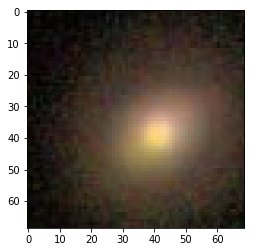

In [36]:
#random image to print
n=int(np.random.uniform(0,maxim,1))

if Y[n]==0:
    mor="elliptical"
else:
    mor="spiral"
print("Morphology: ", mor)    
plt.imshow(D[n,:,:,:].astype(int))

# Define features and labels 
This cell defines the input features to yout ML learning algorithm (we will use Random Forests here)

In [16]:


#define features to use (Your x vector) - here I am using only color and Sersic Index
# You can try different ones from the catalog

# number of features
nf=2
f1=data['g-r'] #color
f2=data['n_r'] #Sersic index

#define two classes (early/late)
# in the example I am selection only 2 broad classes (early/late). You can try other cuts for more challenging problems!
#for example: try to get S0s...
# -5--> E
# -3 to -2 --> S0
# 0 --> S0/a
# 1 --> Sa
# 2 --> Sab
# 3 --> Sb
# 4 --> Sbc
# 5 --> Sc
# 7 --> Sd
# > 8 --> Im etc..

ttype=data["TType"]
m=ttype*0-1
m[np.where((ttype>0) & ((ttype<=10)))]=1
m[np.where((ttype<=0) & ((ttype>=-5)))]=0


#remove bad values
p=np.where((f1>-1) & (f1<2) & (f2>0) & (f2<6) & (m>=0))


#target vector
label_vector=m[p]

#feature vector
feature_vector=np.zeros((label_vector.shape[0],2))
feature_vector[:,0]=f1[p]
feature_vector[:,1]=f2[p]


#divide test/train datasets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, label_vector, test_size=0.33, random_state=42)
print("Sizes training / test")
print(X_train.shape)
print(X_test.shape)

Sizes training / test
(7975, 2)
(3928, 2)


In [17]:
feature_vector

array([[0.547     , 2.52999997],
       [0.674     , 2.1099999 ],
       [0.561     , 2.08999991],
       ...,
       [0.854     , 3.46000004],
       [0.75      , 3.45000005],
       [0.614     , 2.8599999 ]])

In [18]:
feature_vector_2 = np.column_stack((f1[p], f2[p]))

# Plot featues histograms

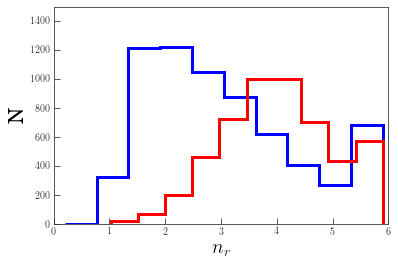

(array([1.000e+00, 1.000e+00, 2.000e+00, 1.200e+01, 3.800e+01, 1.440e+02,
        5.710e+02, 3.558e+03, 8.750e+02, 6.000e+00]),
 array([0.064 , 0.1551, 0.2462, 0.3373, 0.4284, 0.5195, 0.6106, 0.7017,
        0.7928, 0.8839, 0.975 ]),
 <a list of 1 Patch objects>)

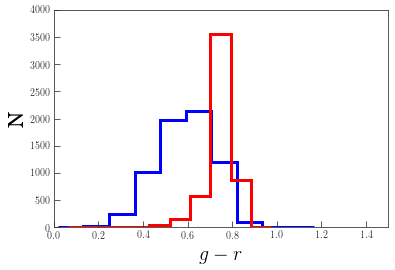

In [19]:
plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1500)
plt.hist(feature_vector[label_vector==1,1],histtype='step',color='blue',linewidth=3)
plt.hist(feature_vector[label_vector==0,1],histtype='step',color='red',linewidth=3)
plt.show()
plt.xlabel("$g-r$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.xlim(0,1.5)
plt.ylim(0,4000)
plt.hist(feature_vector[label_vector==1,0],histtype='step',color='blue',linewidth=3)
plt.hist(feature_vector[label_vector==0,0],histtype='step',color='red',linewidth=3)

In [20]:
matplotlib.matplotlib_fname()

'/Users/victor2/.matplotlib/matplotlibrc'

# Plot 2D feature space

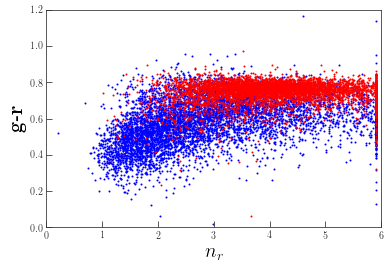

In [21]:
# you can try different parameters. only works in 2D

plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("g-r", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1.2)
plt.scatter(feature_vector[label_vector==1,1],feature_vector[label_vector==1,0],color='blue',s=1)
plt.scatter(feature_vector[label_vector==0,1],feature_vector[label_vector==0,0],color='red',s=1)

# Train
Trains the Random Forest Algorithm.
Feel free to try other learning algorithms

In [22]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print("Trained RF Classifier")
print(clf)
print("Importance of each feature")
print(clf.feature_importances_)

Trained RF Classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Importance of each feature
[0.51027257 0.48972743]


/Users/victor2/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Test
Now we test the performance on the test set

In [24]:
y_pred

array([[0.64266541, 0.35733459],
       [0.258898  , 0.741102  ],
       [0.05332355, 0.94667645],
       ...,
       [0.33093677, 0.66906323],
       [0.05332355, 0.94667645],
       [0.50119855, 0.49880145]])

Global Accuracy: 0.8228105906313645


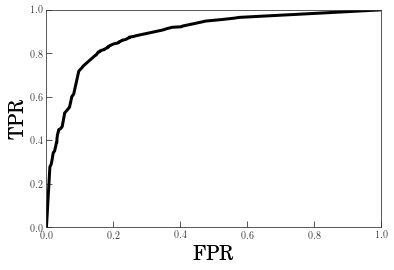

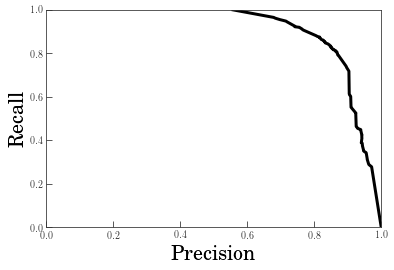

In [23]:

# predicts using the test set (not training at this stage)
y_pred=clf.predict(X_test)

#global accuracy

print("Global Accuracy:", accuracy_score(y_test, y_pred))

# we predict probabilities to plot the ROC curve
y_pred=clf.predict_proba(X_test)

# ROC curve (False positive rate vs. True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

#plot ROC
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr,linewidth=3,color='black')
plt.show()


# ROC curve (False positive rate vs. True positive rate)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

#plot ROC
plt.xlabel("Precision", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(precision,recall,linewidth=3,color='black')
plt.show()


# Visualize bad classifications by the Random Forest in the feature space

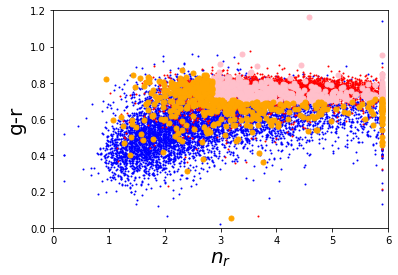

In [131]:
# objects classifed as early-types by the NN but visually classifed as late-types
bad = np.where((y_pred[:,1]<0.5)&(y_test==1))

# objects classifed as late-types by the NN but visually classifed as early-types
bad2 = np.where((y_pred[:,1]>0.5)&(y_test==0))

#visualize the feature space
plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("g-r", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1.2)
plt.scatter(feature_vector[label_vector==1,1],feature_vector[label_vector==1,0],color='blue',s=1)
plt.scatter(feature_vector[label_vector==0,1],feature_vector[label_vector==0,0],color='red',s=1)
plt.scatter(X_test[bad[0],1],X_test[bad[0],0],color='pink',s=25)
plt.scatter(X_test[bad2[0],1],X_test[bad2[0],0],color='orange',s=25)

# Train with fully connected Artifiical Neural Network on catalog data

In [25]:
# some hyperparamters to be changed
nb_epoch=50
batch_size=50

# nueral network with 1 hidden layer of 5 neurons. You can add/remove layers and see the performance. Also change the optimizers.
ann = Sequential()
ann.add(Flatten(input_shape=(nf,1)))
ann.add(Dense(5,activation='relu'))
ann.add(Dense(1,activation="sigmoid"))
ann.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
Xexp=np.expand_dims(X_train,2)
print(Xexp.shape)
ann.fit(Xexp,y_train,nb_epoch=nb_epoch,batch_size=50)

(7975, 2, 1)


/Users/victor2/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/50
7975/7975 [==============================] - 1s 79us/step - loss: 0.6925 - acc: 0.5406
Epoch 2/50
7975/7975 [==============================] - 0s 28us/step - loss: 0.6790 - acc: 0.7239
Epoch 3/50
7975/7975 [==============================] - 0s 25us/step - loss: 0.6688 - acc: 0.6998
Epoch 4/50
7975/7975 [==============================] - 0s 25us/step - loss: 0.6596 - acc: 0.7067
Epoch 5/50
7975/7975 [==============================] - 0s 27us/step - loss: 0.6510 - acc: 0.6958
Epoch 6/50
7975/7975 [==============================] - 0s 26us/step - loss: 0.6426 - acc: 0.6809
Epoch 7/50
7975/7975 [==============================] - 0s 33us/step - loss: 0.6344 - acc: 0.6907
Epoch 8/50
7975/7975 [==============================] - 0s 30us/step - loss: 0.6270 - acc: 0.6900
Epoch 9/50
7975/7975 [==============================] - 0s 30us/step - loss: 0.6190 - acc: 0.6910
Epoch 10/50
7975/7975 [==============================] - 0s 27us/step - loss: 0.6115 - acc: 0.6884
Epoch 11/50
7975/79

# Test on test dataset (compare with Random Forests)

Global Accuracy: 0.8189918533604889


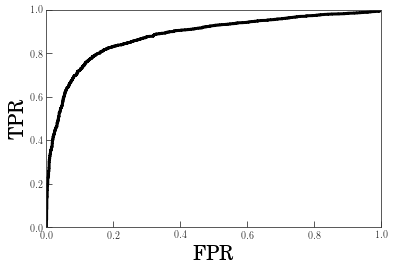

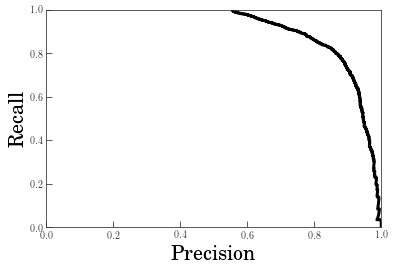

In [26]:
# predicts using the test set (not training at this stage)
y_pred=ann.predict_classes(np.expand_dims(X_test,2))

#global accuracy

print("Global Accuracy:", accuracy_score(y_test, y_pred))

# we predict probabilities to plot the ROC curve
y_pred=ann.predict(np.expand_dims(X_test,2))

# ROC curve (False positive rate vs. True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

#plot ROC
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr,linewidth=3,color='black')
plt.show()


# ROC curve (False positive rate vs. True positive rate)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

#plot ROC
plt.xlabel("Precision", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(precision,recall,linewidth=3,color='black')
plt.show()

# Visualize bad classifications

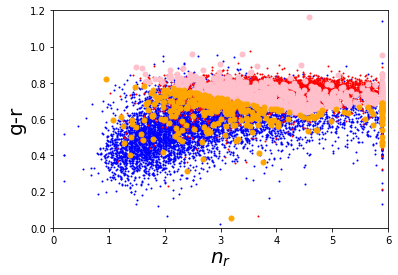

In [128]:
# objects classifed as early-types by the NN but visually classifed as late-types
bad = np.where((y_pred[:,0]<0.5)&(y_test==1))

# objects classifed as late-types by the NN but visually classifed as early-types
bad2 = np.where((y_pred[:,0]>0.5)&(y_test==0))

#visualize the feature space
plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("g-r", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1.2)
plt.scatter(feature_vector[label_vector==1,1],feature_vector[label_vector==1,0],color='blue',s=1)
plt.scatter(feature_vector[label_vector==0,1],feature_vector[label_vector==0,0],color='red',s=1)
plt.scatter(X_test[bad[0],1],X_test[bad[0],0],color='pink',s=25)
plt.scatter(X_test[bad2[0],1],X_test[bad2[0],0],color='orange',s=25)

# Visualize Random Forest tree [optional - requires external software]

In [137]:
i_tree = 0
for tree_in_forest in clf.estimators_:
    with open("RF_ML.dot", "w") as f:
        f = export_graphviz(tree_in_forest, out_file=f)
    i_tree = i_tree + 1    
os.system('dot -Tpng RF_ML.dot -o RF_ML.png')

6